# Anomaly Detection using SDTW

## Importations

In [1]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

np.random.seed(seed=1)

In [2]:
# Environement setup
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
kaggle = True

# 4.1 Experiment on Pytorch SDTW Library
n_max = 120

# 4.4 Experiment on Anomaly Detection
# You can uses as dataset:
# "ElectricDevices"
# "PhalangesOutlinesCorrect"
# "DistalPhalanxOutlineCorrect"
# "TwoPatterns"
# "Wafer"
dataset_name_ts = "MiddlePhalanxOutlineCorrect"

# Train the models :
train_mse = True
train_dtw = True
path_to_models = "/kaggle/input/time-series-models/"

# Compression in the Auto-Encoder
COMPRESSION = 0.1

if kaggle:
    absolute_path = "/kaggle/input/tp3-thales/"
    os.sys.path.append(absolute_path)
    
    # our library
    os.chdir('/kaggle/working')
    !git clone https://github.com/b-ptiste/dtw-soft.git
    os.chdir('/kaggle/working/dtw-soft/code')
    !pip install tslearn
else:
    absolute_path = ""

Cloning into 'dtw-soft'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 18.41 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (56/56), done.
  Obtaining dependency information for tslearn from https://files.pythonhosted.org/packages/97/22/8dba9a7149d51fe0b6163a5a6b7efc315ab3c097cb6b0d1fc649a03f2722/tslearn-0.6.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.2 MB/s eta 0:00:00a 0:00:01


In [3]:
from DTWLoss_CUDA import DTWLoss
from dtw_soft import soft_dtw_batch_same_size

In [4]:
class color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

import IPython
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

class ProgressTrain():
    def __init__(self,imax,Size=50, num_update=100,names = [],epoch_names = ["Train","Test"],time_sleep = 0.01):
        self.imax=imax
        self.i=0
        self.Scale=Size/imax
        self.Size=Size
        self.value_hist = []
        self.names = names
        self.update_rate = int(imax//num_update+1)
        self.epoch = 1
        self.time_sleep = 0.01

        self.out = display(IPython.display.Pretty('Starting'), display_id=True) #
        time.sleep(0.5)

        self.colorList=[color.RED,color.YELLOW,color.PURPLE,color.BLUE,color.CYAN,color.GREEN]
        self.colorList=[x.replace('8m','8m') for x in self.colorList]

        string = ""
        for name in ["Remaining Time"]+names:
            string += self.show(name,n = max(9,len(name))) + ' || '

        epoch_string = ""
        for name in epoch_names:
            epoch_string += self.show(name) + ' || '
        self.epoch_names = ["Train Loss","Test Loss"] + epoch_names

        print("-"*(Size+10)+"|| "+string)
        if epoch_string == "":
            print("||----||   Epoch   ||          Loss          || ")
            print("||----||   Time    ||   Train   ||   Test    || ")
        else:
            print("||----||   Epoch   ||          Loss          || "+"Others".center(len(epoch_string)-4)+" ||")
            print("||----||   Time    ||   Train   ||   Test    || "+epoch_string)
        time.sleep(0.5)

        self.start_time = time.time()

        self.update()
        
    def update(self,x=[]):
        if self.i%self.update_rate == 0:

            Color=self.colorList[min(len(self.colorList)-1,round(self.i/self.imax*(len(self.colorList)-1)))]

            def format_number(x, n=5):
                return "{:>{width}.2f}".format(x, width=n)
            
            def format_delta_time(delta):
                hours = int(delta // 3600)
                minutes = int((delta % 3600) // 60)
                seconds = int(delta % 60)
                return "{:02}h{:02}m{:02}s".format(hours, minutes, seconds)
            
            if self.i == 0:
                remaining_time = 0
            else:
                remaining_time = (time.time()-self.start_time)*(self.imax/(self.i+0.0001)-1)

            x = [format_delta_time(remaining_time)] + x

            string = Color+'['+'%'*round(self.i*self.Scale)+'-'*round((self.imax-self.i)*self.Scale)+'] '+format_number(100*self.i/(self.imax))+'%'+color.END
            string += color.BOLD
            for value,name in zip(x,["Remaining Time"]+self.names):
                string += ' || '+self.show(value,n = max(9,len(name)))

            string += color.END+' ||   '

            self.out.update(IPython.display.Pretty(string))
            time.sleep(self.time_sleep)
        
        self.i+=1

    def show(self,x,n=9,c=None):
        if n<5:
            assert "To short to show"
        if type(x)==int or type(x)==float:
            if (x>=(10**4) or x<=(10**(-4))) and x >0:
                out = ("{:."+str(n-6)+"e}").format(x)
            elif (x<=-(10**4) or x>=-(10**(-4))) and x < 0:
                out = ("{:."+str(n-7)+"e}").format(x)
            else:
                out = str(x)[:n]
        elif type(x)==str:
            
            if len(x)>n:
                out = x[:n]
            else:
                out = x.center(n)
        else:
            out = str(x)[:n]
        
        if c is None:
            return out + " "*max((n-len(out)),0)
        else:
            return c + out + " "*max((n-len(out)),0) + color.END
        

    def end(self,x=[],kaggle = False):
        self.i-=1

        def format_integer(x, n=3):
            return "{:>{width}}".format(x, width=n)
        
        def format_delta_time(delta):
                hours = int(delta // 3600)
                minutes = int((delta % 3600) // 60)
                seconds = int(delta % 60)
                return "{:02}h{:02}m{:02}s".format(hours, minutes, seconds)
            
        total_time = time.time()-self.start_time

        x = [format_delta_time(total_time)] + x
        
        if self.i==self.imax:
            string = '||'+color.GREEN+format_integer(self.epoch)+color.END #+'' + color.BOLD
            
        else:
            string = color.YELLOW+'||'+format_integer(self.epoch)+color.END+'' + color.BOLD
        for k, value in enumerate(x):
            if self.epoch == 1 or k==0:
                string += ' || '+self.show(value)
            else:
                if value < self.value_hist[-1][k-1]:
                    if k>2:
                        string += ' || '+self.show(value,c = color.RED)
                    else:
                        if value < min(np.array(self.value_hist)[:,k-1]):
                            string += ' || '+self.show(value,c = color.GREEN)
                        else:
                            string += ' || '+self.show(value,c = color.YELLOW)
                elif value > self.value_hist[-1][k-1]:
                    if k>2:
                        if value > max(np.array(self.value_hist)[:,k-1]):
                            string += ' || '+self.show(value,c = color.GREEN)
                        else:
                            string += ' || '+self.show(value,c = color.YELLOW)
                    else:
                        string += ' || '+self.show(value,c = color.RED)
                else:
                    string += ' || '+self.show(value)
        
        string += ' || '
        self.i=0
        self.update()
        self.value_hist.append(x[1:])
        self.epoch += 1
        self.start_time = time.time()

        if kaggle:
            return string
        else:
            print(string)
        

        
    def get(self,input_names):

        data = np.transpose(np.array(self.value_hist))
        if not isinstance(input_names, list):
            input_names = [input_names]
        # Find indices of the input names
        indices = [self.epoch_names.index(name) for name in input_names if name in self.epoch_names]
        # Extract and return the data for these indices
        return [data[index] for index in indices]

    def plot(self, input_names = ["Train Loss","Test Loss"]):
        
        if self.epoch == 1:
            return 0

        data = np.transpose(np.array(self.value_hist))
        # Ensure input_names is a list
        if isinstance(input_names, str):
            input_names = [input_names]
        
        plt.figure(figsize=(10, 4)) 
        # Plot data for each name in input_names
        for name in input_names:
            if name in self.epoch_names:
                index = self.epoch_names.index(name)
                plt.plot(range(1,len(data[index])+1),data[index], label=name)

        # Set plot features
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title(', '.join(input_names)+ " Evolution.")
        plt.legend()
        #plt.grid()
        
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        plt.show()


## 4.1 Pytorch Implementation

In [5]:
gamma = 1
def sdtw_loss(x,x_predicted):
    return torch.mean(soft_dtw_batch_same_size(x,x_predicted,gamma)[0])

criterion_auto = sdtw_loss
criterion_custom = DTWLoss(gamma)

In [6]:
# Initialize variables
n_values = range(n_max)
times_front_auto_ = [0]
times_back_auto_ = [0]
times_front_custom_ = [0]
times_back_custom_ = [0]

# Compute loss and time for each n
for n in n_values[1:]:
    print(n,end='\r')
    
    # Auto
    x = torch.ones(16, n, 2).requires_grad_() 
    start_time_auto = time.time()
    loss = criterion_auto(x, x)
    mid_time_auto = time.time()
    loss.backward()
    end_time_auto = time.time()
    
    # Custom
    x = torch.ones(16, n, 2).requires_grad_() 
    start_time_custom = time.time()
    loss = criterion_custom(x, x)
    mid_time_custom = time.time()
    loss.backward()
    end_time_custom = time.time()
    
    
    times_front_auto_.append(mid_time_auto - start_time_auto)
    times_back_auto_.append(end_time_auto - mid_time_auto)
    
    times_front_custom_.append(mid_time_custom - start_time_custom)
    times_back_custom_.append(end_time_custom - mid_time_custom)
    
print("Done !")

Done !


Front Auto:    a = 0.000617, b = 1.7173
Back Auto:     a = 0.000383, b = 2.1078
Front Custom:  a = 0.000298, b = 1.8640
Back Custom:   a = 0.000314, b = 1.8895


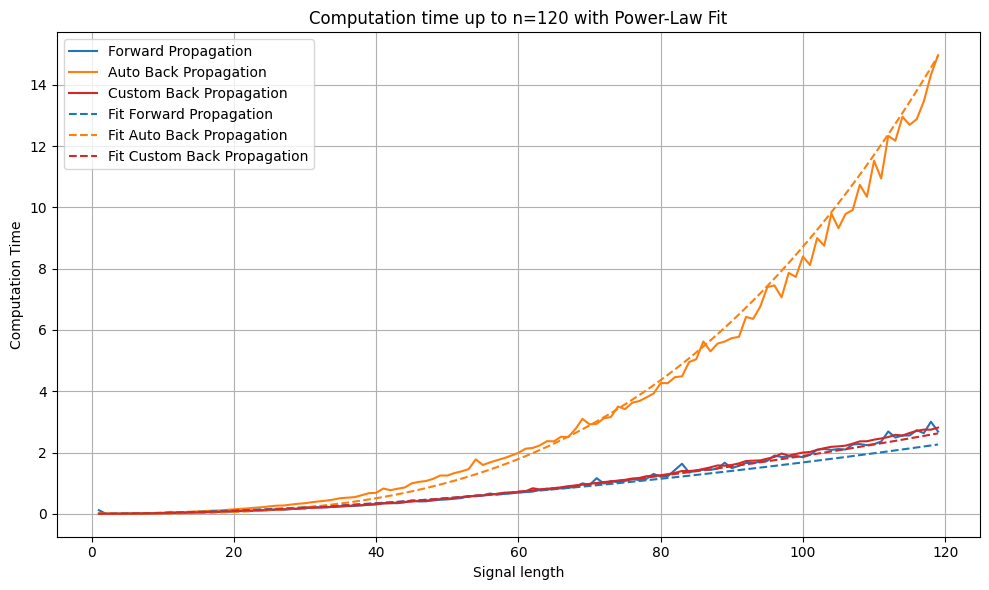

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Convert to numpy arrays and reshape
n_values_ = np.array(n_values).reshape(-1, 1)
times_front_auto = np.array(times_front_auto_)
times_back_auto = np.array(times_back_auto_)
times_front_custom = np.array(times_front_custom_)
times_back_custom = np.array(times_back_custom_)

# Ensure all values are positive and non-zero
valid_indices = (n_values_.flatten() > 0) & \
                (times_front_auto > 0) & \
                (times_back_auto > 0) & \
                (times_front_custom > 0) & \
                (times_back_custom > 0)
n_values_ = n_values_[valid_indices]
times_front_auto = times_front_auto[valid_indices]
times_back_auto = times_back_auto[valid_indices]
times_front_custom = times_front_custom[valid_indices]
times_back_custom = times_back_custom[valid_indices]

# Function to fit and return a power-law model (a*x^b)
def power_law_fit(x, y):
    log_x = np.log(x)
    log_y = np.log(y)
    model = LinearRegression().fit(log_x, log_y)
    a = np.exp(model.intercept_)
    b = model.coef_[0]
    return a, b

# Compute coefficients for power-law fits
a_front_auto, b_front_auto = power_law_fit(n_values_, times_front_auto)
a_back_auto, b_back_auto = power_law_fit(n_values_, times_back_auto)
a_front_custom, b_front_custom = power_law_fit(n_values_, times_front_custom)
a_back_custom, b_back_custom = power_law_fit(n_values_, times_back_custom)

# Print coefficients with better formatting
print(f'Front Auto:    a = {a_front_auto:.6f}, b = {b_front_auto:.4f}')
print(f'Back Auto:     a = {a_back_auto:.6f}, b = {b_back_auto:.4f}')
print(f'Front Custom:  a = {a_front_custom:.6f}, b = {b_front_custom:.4f}')
print(f'Back Custom:   a = {a_back_custom:.6f}, b = {b_back_custom:.4f}')

# Plotting
#fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig, axe = plt.subplots(1, 1, figsize=(10, 6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

mna = n_max
plot_power = True

#mna = 80
#plot_power = False

# Normal scale plot with power-law regression
axe.plot(n_values_[:mna], times_front_auto[:mna], label='Forward Propagation',color=colors[0])
axe.plot(n_values_[:mna], times_back_auto[:mna], label='Auto Back Propagation',color=colors[1])
#axe.plot(n_values_[:mna], times_front_custom[:mna], label='Front Custom',color=colors[2])
axe.plot(n_values_[:mna], times_back_custom[:mna], label='Custom Back Propagation',color=colors[3])

if plot_power:
    n_values_range = np.linspace(np.min(n_values_[:mna]), np.max(n_values_[:mna]), 100).reshape(-1, 1)
    axe.plot(n_values_range, a_front_auto * n_values_range ** b_front_auto, label='Fit Forward Propagation', linestyle='dashed', color=colors[0])
    axe.plot(n_values_range, 0.0000055 * n_values_range ** 3.1, label='Fit Auto Back Propagation', linestyle='dashed', color=colors[1])
    #axe.plot(n_values_range, a_front_custom * n_values_range ** b_front_custom, label='Fit Front Custom', linestyle='dashed', color=colors[2])
    axe.plot(n_values_range, a_back_custom * n_values_range ** b_back_custom, label='Fit Custom Back Propagation', linestyle='dashed', color=colors[3])
    axe.set_title('Computation time up to n=' + str(mna) + ' with Power-Law Fit')
else:
    axe.set_title('Computation time up to n=' + str(mna))
axe.set_xlabel('Signal length')
axe.set_ylabel('Computation Time')
axe.legend()
axe.grid()

plt.tight_layout()
plt.show()

In [8]:
n = 15
print("n          :",n)
# Auto
x = torch.ones(16, n, 2).requires_grad_() 
start_time = time.time()
loss = criterion_auto(x, x)
mid_time = time.time()
loss.backward()
end_time = time.time()
print("Front Auto :",mid_time-start_time,"s")
print("Back  Auto :",end_time-mid_time,"s")

# Custom CPU
x = torch.ones(16, n, 2).requires_grad_() 
start_time = time.time()
loss = criterion_custom(x, x)
mid_time = time.time()
loss.backward()
end_time = time.time()
print("Front CPU  :",mid_time-start_time,"s")
print("Back  CPU  :",end_time-mid_time,"s")

# Custom GPU
try:
    x = torch.ones(16, n, 2).requires_grad_().to('cuda:0') 
    start_time = time.time()
    loss = criterion_custom(x, x)
    mid_time = time.time()
    loss.backward()
    end_time = time.time()
    print("Front GPU  :",mid_time-start_time,"s")
    print("Back  GPU  :",end_time-mid_time,"s")
except:
    print("No GPU avalable")

n          : 15
Front Auto : 0.04801750183105469 s
Back  Auto : 0.0762631893157959 s
Front CPU  : 0.03715085983276367 s
Back  CPU  : 0.04603004455566406 s
No GPU avalable


## 4.4 Anomaly detection

### Dataset

In [9]:
from tslearn.datasets import UCR_UEA_datasets
# Load the dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name_ts)

# Print the number of samples in the test and train set
print("Number of samples in the training set:", len(X_train))
print("Number of samples in the test set:", len(X_test))

# Print the shape of the signals
print("Shape of the training signals:", X_train.shape)
print("Shape of the test signals:", X_test.shape)

# Count the occurrences of each class in the training and test sets
train_class_counts = dict(zip(*np.unique(y_train, return_counts=True)))
test_class_counts = dict(zip(*np.unique(y_test, return_counts=True)))

# Print the counts for each class in the training set
print("Training set class counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count}")

# Print the counts for each class in the test set
print("\nTest set class counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count}")
i=0

Number of samples in the training set: 600
Number of samples in the test set: 291
Shape of the training signals: (600, 80, 1)
Shape of the test signals: (291, 80, 1)
Training set class counts:
Class 0: 212
Class 1: 388

Test set class counts:
Class 0: 125
Class 1: 166


('0000000000', 1)

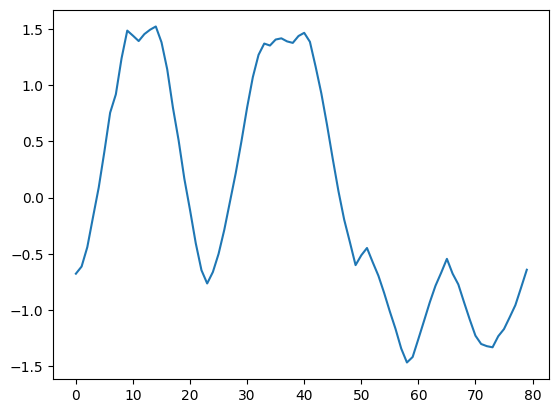

In [10]:
i+=1
plt.plot(X_test[i])
str(y_test[i])*10,i

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels=None):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        anomaly = self.labels[idx]
    
        return signal.reshape(1, -1), anomaly

X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name_ts)

mid_index = len(X_test) // 2
X_valid, y_valid = X_test[:mid_index], y_test[:mid_index]
X_test, y_test = X_test[mid_index:], y_test[mid_index:]

print("X_train      :",X_train.shape)
print("X_valid      :",X_valid.shape)
print("X_test       :",X_test.shape)

# 2. Keep in the train only the first half of the classes
unique_classes = np.unique(y_train)
mid_class_index = len(unique_classes) // 2
classes_to_keep = unique_classes[mid_class_index:]

# Filter X_train and y_train for the first half of the classes
is_class_in_first_half = np.isin(y_train, classes_to_keep)
X_train, y_train = X_train[is_class_in_first_half], y_train[is_class_in_first_half]

is_class_in_first_half = np.isin(y_valid, classes_to_keep)
X_valid, y_valid = X_valid[is_class_in_first_half], y_valid[is_class_in_first_half]

# 3. For the test, mark labels as True if seen in train (no anomaly), else False
# Convert y_train to a set for efficient lookup
train_classes_set = set(y_train)
y_test = np.array([True if label in train_classes_set else False for label in y_test])

# Creating datasets
dataset_train = MyDataset(X_train, y_train)
dataset_valid = MyDataset(X_valid, y_valid)
dataset_test = MyDataset(X_test, y_test)

print("Classes      :",unique_classes)
print("Classes Train:",classes_to_keep)
print()
print("X_train      :",X_train.shape)
print("X_valid      :",X_valid.shape)
print("X_test       :",X_test.shape)
print()
print("Nb Signals train         :",len(dataset_train))
print("Nb Signals valid         :",len(dataset_valid))
print("Nb Signals test          :",len(dataset_test))
print("Input Dim                :",dataset_train[0][0].shape)
i = 0

X_train      : (600, 80, 1)
X_valid      : (145, 80, 1)
X_test       : (146, 80, 1)
Classes      : [0 1]
Classes Train: [1]

X_train      : (388, 80, 1)
X_valid      : (82, 80, 1)
X_test       : (146, 80, 1)

Nb Signals train         : 388
Nb Signals valid         : 82
Nb Signals test          : 146
Input Dim                : (1, 80)


### Model
#### Autoencoder

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,input_shape = dataset_train[0][0].shape[1],compression = COMPRESSION,features = dataset_train[0][0].shape[0]):
        super(Autoencoder, self).__init__()

        # Define the dimensions
        self.signal_len = input_shape
        self.in_channels = features  # Assuming input is grayscale
        self.out_channels = 16  # Arbitrary number of output channels for conv layers

        # Convolutional encoding layers
        self.conv1 = nn.Conv1d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(self.out_channels, self.out_channels * 2, kernel_size=3, stride=1, padding=1)
        self.enc_linear_input_features = input_shape * self.out_channels * 2  # Calculate from conv output size

        # Intermediate and encoding dimensions
        mid_features = int(input_shape*np.sqrt(compression))  # Intermediate features
        encoding_dim = int(input_shape*compression)  # Encoded dimension

        # Encoding FC layers
        self.fc1 = nn.Linear(self.enc_linear_input_features, mid_features)
        self.fc2 = nn.Linear(mid_features, encoding_dim)

        # Decoding FC layers
        self.fc3 = nn.Linear(encoding_dim, mid_features)
        self.fc4 = nn.Linear(mid_features, self.enc_linear_input_features)

        # Decoding Convolutional layers to reshape back to original
        self.deconv1 = nn.ConvTranspose1d(self.out_channels * 2, self.out_channels, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose1d(self.out_channels, self.in_channels, kernel_size=3, stride=1, padding=1)
        
        print("Type        :","2 conv 2 fc")
        print("Input Len   :",self.signal_len)
        print("Input Featur:",self.in_channels)
        print("Out channels:",self.out_channels)
        print("Mid features:",mid_features)
        print("In Features :",encoding_dim)
    def forward(self, x):
        # Applying two convolutions at the beginning
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten input for the linear layers
        x = x.reshape(x.size(0), -1)

        # Encoding
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Decoding
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        # Reshaping for the deconvolutional layers
        x = x.reshape(x.size(0), self.out_channels * 2, -1)

        # Deconvolutions to get back to original shape
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)

        # Reshape to original input shape (b, 1, signal_len)
        x = x.reshape(x.size(0), 1, self.signal_len)
        return x

total_params = 0
for name, param in Autoencoder().named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:<30} | Number of Parameters: {num_params}")

# Print total parameters in bold
print(f"\033[1mTotal Number of Parameters: {total_params}\033[0m")

test_model = Autoencoder()
out = test_model(torch.ones(dataset_train[0][0].shape).unsqueeze(0))
print(out.shape)
print(torch.mean(out),torch.var(out))

Type        : 2 conv 2 fc
Input Len   : 80
Input Featur: 1
Out channels: 16
Mid features: 25
In Features : 8
conv1.weight                   | Number of Parameters: 48
conv1.bias                     | Number of Parameters: 16
conv2.weight                   | Number of Parameters: 1536
conv2.bias                     | Number of Parameters: 32
fc1.weight                     | Number of Parameters: 64000
fc1.bias                       | Number of Parameters: 25
fc2.weight                     | Number of Parameters: 200
fc2.bias                       | Number of Parameters: 8
fc3.weight                     | Number of Parameters: 200
fc3.bias                       | Number of Parameters: 25
fc4.weight                     | Number of Parameters: 64000
fc4.bias                       | Number of Parameters: 2560
deconv1.weight                 | Number of Parameters: 1536
deconv1.bias                   | Number of Parameters: 16
deconv2.weight                 | Number of Parameters: 48
deconv2.

### Training Pipeline

In [13]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score >= self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [14]:
def TRAIN():
    try:
        P = ProgressTrain(len(ae_tdl),epoch_names = [],names = ["Batch Loss","Grad Model","Grad x"],time_sleep = 0)
        loss_hist = []
        for epoch in range(max_epoch):

            model.train()  # Set the model to training mode

            for x in ae_tdl:
                x = x[0].to(device).float()

                optimizer.zero_grad()

                x_predicted = model(x)

                l = loss(x_predicted.transpose(1,2), x.transpose(1,2))
                l.backward()
                optimizer.step()

                # Log training loss
                loss_hist.append(l.item())
                
                mean_grad = sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None) / len([p for p in model.parameters() if p.grad is not None])
                #x_grad = x_predicted.grad.abs().mean().item() if x_predicted.grad is not None else 0
                x_grad = 0
                
                P.update([l.item(),mean_grad,x_grad])



            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                total_loss_valid = 0
                for x in ae_vdl:
                    x = x[0].to(device).float()
                    x_predicted = model(x)
                    l = loss(x_predicted.transpose(1,2), x.transpose(1,2))
                    total_loss_valid += l.item()


            mean_loss_train = np.sum(np.array(loss_hist)[-len(ae_tdl):])/len(ae_tdl)
            mean_loss_valid = total_loss_valid/len(ae_vdl)

            P.end([mean_loss_train,mean_loss_valid])

            es(mean_loss_valid)

            if es.best_score == mean_loss_valid:
                torch.save(model, save_model)

            if es.early_stop:
                print("Early stopping triggered")
                break

        P.plot()
            
    except KeyboardInterrupt:
        torch.save(model, save_model)
        print("Training interrupted and model saved.")
        P.plot()

### Training

In [15]:
print("="*20," Model Infos ","="*20)
model = Autoencoder()
print()
batch_size = 32

ae_tdl, ae_vdl = DataLoader(dataset_train, batch_size=batch_size), DataLoader(dataset_valid, batch_size=batch_size)

es = EarlyStopping(patience=7)

max_epoch = 70
learning_rate = 0.03
optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
save_model = '/kaggle/working/' + "Model_MSE" + ".pt"

loss = nn.MSELoss()


print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(ae_tdl))
print("Valid Dataloader Len :",len(ae_vdl))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :","MSE")


====================  Model Infos  ====================
Type        : 2 conv 2 fc
Input Len   : 80
Input Featur: 1
Out channels: 16
Mid features: 25
In Features : 8

====================  Data  Infos  ====================
Train Dataloader Len : 13
Valid Dataloader Len : 3
Batch size           : 32

====================  Train Infos  ====================
Max Epoch            : 70
Early Stopping       : 5
Optimizer            : Adam
Learning Rate        : 0.03
Device               : cpu
Save model path      : /kaggle/working/Model_MSE.pt

====================  Loss  Infos  ====================
Loss                 : MSE


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || Grad Model ||   Grad x  || 
||----||   Epoch   ||          Loss          || 
||----||   Time    ||   Train   ||   Test    || 
||  1 || 00h00m00s || 0.9133745 || 0.4199233 || 
||  2 || 00h00m00s || 0.1320706 || 0.0780531 || 
||  3 || 00h00m00s || 0.0461120 || 0.0471912 || 
||  4 || 00h00m00s || 0.0298688 || 0.0477794 || 
||  5 || 00h00m00s || 0.0288523 || 0.0456813 || 
||  6 || 00h00m00s || 0.0277893 || 0.0449797 || 
||  7 || 00h00m00s || 0.0273913 || 0.0448486 || 
||  8 || 00h00m00s || 0.0272689 || 0.0448945 || 
||  9 || 00h00m00s || 0.0272346 || 0.0443380 || 
|| 10 || 00h00m00s || 0.0268317 || 0.0435340 || 
|| 11 || 00h00m00s || 0.0262100 || 0.0421306 || 
|| 12 || 00h00m00s || 0.0250662 || 0.0391413 || 
|| 13 || 00h00m00s || 0.0225081 || 0.0377264 || 
|| 14 || 00h00m00s || 0.0196192 || 0.0403956 || 
|| 15 || 00h00m00s || 0.0195243 || 0.0413373 || 
|| 16 || 00h00m00s || 0.0178804 || 0.0438815

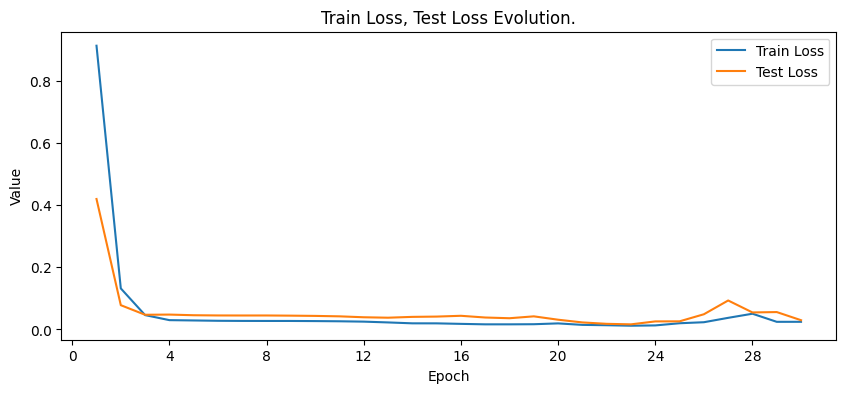

In [16]:
if train_mse or True:
    TRAIN()


========== Gamma : 1 ==========
Type        : 2 conv 2 fc
Input Len   : 80
Input Featur: 1
Out channels: 16
Mid features: 25
In Features : 8


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || Grad Model ||   Grad x  || 
||----||   Epoch   ||          Loss          || 
||----||   Time    ||   Train   ||   Test    || 
||  1 || 00h00m33s || -55.84820 || -99.06214 || 
||  2 || 00h00m33s || -112.2065 || -113.6031 || 
||  3 || 00h00m33s || -119.6147 || -118.1330 || 
||  4 || 00h00m33s || -121.7666 || -119.8677 || 
||  5 || 00h00m33s || -122.6964 || -120.3029 || 
||  6 || 00h00m33s || -123.1904 || -120.5821 || 
||  7 || 00h00m33s || -123.4932 || -120.8858 || 
||  8 || 00h00m33s || -123.7551 || -121.1111 || 
||  9 || 00h00m33s || -123.9504 || -121.2753 || 
|| 10 || 00h00m33s || -124.1010 || -121.3892 || 
|| 11 || 00h00m33s || -124.2159 || -121.4959 || 
|| 12 || 00h00m33s || -124.3182 || -121.5890 || 
|| 13 || 00h00m33s || -124.4085 || -121.6638 || 
|| 14 || 00h00m33s || -124.4845 || -121.7520 || 
|| 15 || 00h00m33s || -124.5593 || -121.8163 || 
|| 16 || 00h00m33s || -124.6184 || -121.8440

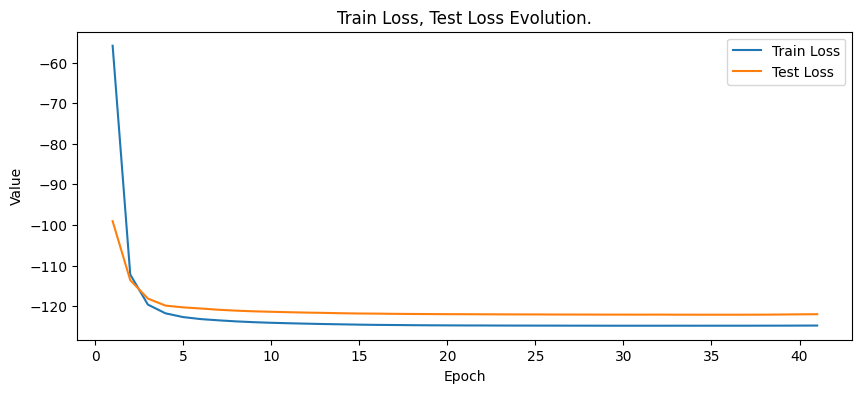


========== Gamma : 0.1 ==========
Type        : 2 conv 2 fc
Input Len   : 80
Input Featur: 1
Out channels: 16
Mid features: 25
In Features : 8


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || Grad Model ||   Grad x  || 
||----||   Epoch   ||          Loss          || 
||----||   Time    ||   Train   ||   Test    || 
||  1 || 00h00m33s || 13.144631 || -0.366320 || 
||  2 || 00h00m33s || -3.898036 || -5.470659 || 
||  3 || 00h00m33s || -7.151496 || -6.588479 || 
||  4 || 00h00m33s || -7.889311 || -6.910356 || 
||  5 || 00h00m34s || -8.063388 || -7.079703 || 
||  6 || 00h00m33s || -8.107626 || -6.776653 || 
||  7 || 00h00m33s || -8.261698 || -7.070945 || 
||  8 || 00h00m33s || -8.582201 || -7.374967 || 
||  9 || 00h00m33s || -8.791016 || -7.794339 || 
|| 10 || 00h00m33s || -9.066646 || -7.787032 || 
|| 11 || 00h00m33s || -9.055122 || -7.760405 || 
|| 12 || 00h00m33s || -8.854561 || -5.838288 || 
|| 13 || 00h00m33s || -8.102435 || -5.598718 || 
|| 14 || 00h00m33s || -8.340566 || -8.163372 || 
|| 15 || 00h00m33s || -9.044481 || -7.910103 || 
|| 16 || 00h00m33s || -9.136772 || -7.945603

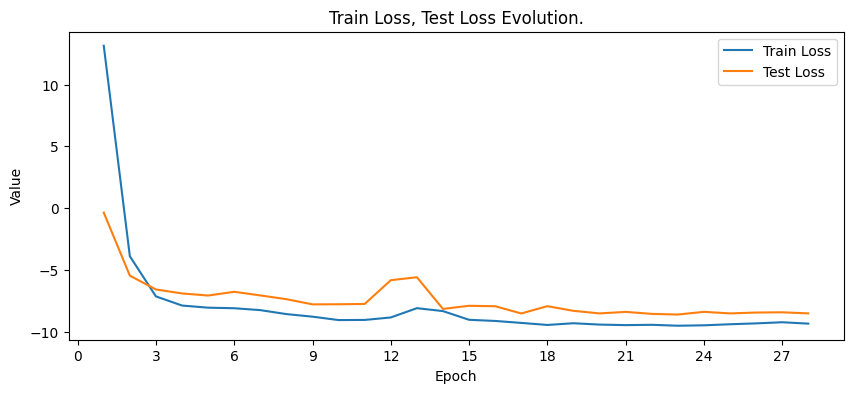


========== Gamma : 0.01 ==========
Type        : 2 conv 2 fc
Input Len   : 80
Input Featur: 1
Out channels: 16
Mid features: 25
In Features : 8


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || Grad Model ||   Grad x  || 
||----||   Epoch   ||          Loss          || 
||----||   Time    ||   Train   ||   Test    || 
||  1 || 00h00m34s || 23.652449 || 9.3259881 || 
||  2 || 00h00m34s || 6.2338246 || 5.9225939 || 
||  3 || 00h00m33s || 4.4744358 || 5.7698003 || 
||  4 || 00h00m34s || 4.4039195 || 5.1080695 || 
||  5 || 00h00m33s || 4.0449299 || 5.5454115 || 
||  6 || 00h00m33s || 4.2569013 || 5.5114151 || 
||  7 || 00h00m33s || 4.2750293 || 5.3893097 || 
||  8 || 00h00m33s || 4.3478822 || 5.5708131 || 
||  9 || 00h00m34s || 4.5375686 || 6.4314848 || 
Early stopping triggered


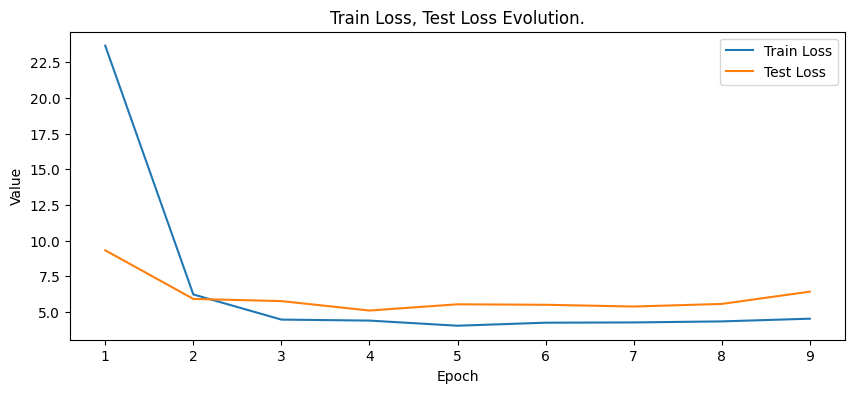


========== Gamma : 0.001 ==========
Type        : 2 conv 2 fc
Input Len   : 80
Input Featur: 1
Out channels: 16
Mid features: 25
In Features : 8


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || Grad Model ||   Grad x  || 
||----||   Epoch   ||          Loss          || 
||----||   Time    ||   Train   ||   Test    || 
||  1 || 00h00m34s || 34.882027 || 6.5204202 || 
||  2 || 00h00m34s || 4.1399253 || 3.1131108 || 
||  3 || 00h00m34s || 1.7669386 || 2.0287686 || 
||  4 || 00h00m34s || 1.2075990 || 1.6994464 || 
||  5 || 00h00m34s || 1.0879706 || 1.3951764 || 


In [ ]:
gammas = [1,0.1,0.01,0.001]
for gamma in gammas:
    print()
    print("="*10,"Gamma :",gamma,"="*10)
    model = Autoencoder().to(device)
    save_model = '/kaggle/working/' + "Model_DTW_" +str(gamma)+ ".pt"
    loss = DTWLoss(gamma)
    es = EarlyStopping(patience=5)
    #batch_size = 128

    max_epoch = 70
    learning_rate = 0.03
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    

    if train_dtw:
        TRAIN()

### Results

In [ ]:
path__ = '/kaggle/working/'
model_MSE = torch.load(path__ + "Model_MSE" + ".pt")

#gammas = [1,0.01]
models_DTW = {}
for gamma in gammas:
    models_DTW[gamma] = torch.load(path__ + "Model_DTW_" + str(gamma) + ".pt")

### Reconstruction for a normal signal

In [ ]:
i = 0
label_temp = True
while label_temp:
    i +=1
    label_temp = dataset_test[i][1]

print(dataset_test[i][1])
input_tensor = torch.tensor(dataset_test[i][0]).to(device).unsqueeze(0).float()
print(input_tensor.shape)
output_tensor_MSE = model_MSE(input_tensor)
outputs_tesor_DTW = []
for k,model in models_DTW.items():
    outputs_tesor_DTW.append(model(input_tensor).cpu().detach().numpy()) 

input_tensor = input_tensor.cpu()
output_tensor_MSE = output_tensor_MSE.cpu()

mse_loss_MSE = F.mse_loss(input_tensor, output_tensor_MSE)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

# Input vs Output for channel 1
axs.plot(input_tensor[0, 0].detach().numpy(), label='Input')
axs.plot(output_tensor_MSE[0, 0].detach().numpy(), label='MSE Reconstruction')
for out,g in zip(outputs_tesor_DTW,models_DTW):
    axs.plot(out[0, 0], label='DTW Reconstruction '+str(g))
axs.set_title('Input vs Output - Normal')
axs.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#print(f'DTW Loss: {mse_loss_DTW.item()}')
print(f'MSE Loss: {mse_loss_MSE.item()}')

### Reconstruction for an anomaly

In [ ]:
i = 0
label_temp = False
while label_temp != True:
    i +=1
    label_temp = dataset_test[i][1]

print(label_temp)
input_tensor = torch.tensor(dataset_test[i][0]).to(device).unsqueeze(0).float()
print(input_tensor.shape)
output_tensor_MSE = model_MSE(input_tensor)
outputs_tesor_DTW = []
for k,model in models_DTW.items():
    outputs_tesor_DTW.append(model(input_tensor).cpu().detach().numpy()) 

input_tensor = input_tensor.cpu()
output_tensor_MSE = output_tensor_MSE.cpu()

mse_loss_MSE = F.mse_loss(input_tensor, output_tensor_MSE)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

# Input vs Output for channel 1
axs.plot(input_tensor[0, 0].detach().numpy(), label='Input')
axs.plot(output_tensor_MSE[0, 0].detach().numpy(), label='MSE Reconstruction')
for out,g in zip(outputs_tesor_DTW,models_DTW):
    axs.plot(out[0, 0], label='DTW Reconstruction '+str(g))
axs.set_title('Input vs Output - Anomaly')
axs.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#print(f'DTW Loss: {mse_loss_DTW.item()}')
print(f'MSE Loss: {mse_loss_MSE.item()}')

### Anomaly detection for MSE

In [ ]:
def get_losses(model,criterion):

    test_ds = dataset_test
    losses = []
    labels = []
    for i in range(len(test_ds)):
        print(round(100*i/len(test_ds),1),"%",end="\r")
        x, lab= test_ds[i]
        x = torch.tensor(x).to(device).unsqueeze(0).float()
        x_predicted = model(x)
        l = criterion(x_predicted, x)
        losses.append(l.item())
        labels.append(lab)

    label_color_mapping = {False: 'blue', True: 'red'}
    test_label_colors = np.array([label_color_mapping[label] for label in labels])

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                       for label, color in label_color_mapping.items()]
    
    return losses,labels,legend_elements,test_label_colors
losses,labels,legend_elements,test_label_colors = get_losses(model_MSE,nn.MSELoss())

In [ ]:
zoom = 10000000
# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(len(losses))[:zoom], losses[:zoom], label='Reconstruction Error', c=test_label_colors[:zoom])
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.grid()
plt.show()

In [ ]:
false_losses = np.array(losses)[np.array(labels)==False]

In [ ]:
# Assuming labels are 0 for normal and 1 for anomaly
thresholds = np.linspace(np.min(false_losses), np.max(np.array(false_losses)), 100)
accuracies = []
recalls = []

for threshold in thresholds:
    predictions = [1 if loss > threshold else 0 for loss in losses]
    accuracies.append(accuracy_score(labels, predictions))
    recalls.append(recall_score(labels, predictions))

# Scatter plot of accuracy vs recall for different thresholds
plt.figure(figsize=(12, 6))
plt.scatter(accuracies, recalls, c=thresholds, cmap='viridis')
plt.colorbar(label='Threshold')
plt.xlabel('Accuracy')
plt.ylabel('Recall')
plt.title('Accuracy vs Recall for Different Thresholds')
plt.grid()
plt.show()

print("Top accuracy",max(accuracies))

In [ ]:
# Plotting accuracy and recall for different thresholds
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and Recall for Different Thresholds')
plt.legend()
plt.grid()
plt.show()

### Anomaly detection for SDTW

In [ ]:
losses,labels,legend_elements,test_label_colors = get_losses(models_DTW[1],DTWLoss(1))

In [ ]:
# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(len(losses)), losses, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.grid()
plt.show()

In [ ]:
false_losses = np.array(losses)[np.array(labels)==False]

In [ ]:
# Assuming labels are 0 for normal and 1 for anomaly
thresholds = np.linspace(np.min(false_losses), np.max(np.array(false_losses)), 100)
accuracies = []
recalls = []

for threshold in thresholds:
    predictions = [1 if loss > threshold else 0 for loss in losses]
    accuracies.append(accuracy_score(labels, predictions))
    recalls.append(recall_score(labels, predictions))

# Scatter plot of accuracy vs recall for different thresholds
plt.figure(figsize=(12, 6))
plt.scatter(accuracies, recalls, c=thresholds, cmap='viridis')
plt.colorbar(label='Threshold')
plt.xlabel('Accuracy')
plt.ylabel('Recall')
plt.title('Accuracy vs Recall for Different Thresholds')
plt.grid()
plt.show()

print("Top accuracy",max(accuracies))

In [ ]:
# Plotting accuracy and recall for different thresholds
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and Recall for Different Thresholds')
plt.legend()
plt.grid()
plt.show()

### Accuracy - Recall for all models

In [ ]:
def plot_model_recall_accuracy(model, criterion, label, ax, linestyle='-'):
    # get losses, labels and other necessary details
    losses, labels, _, _ = get_losses(model,criterion)
    false_losses = np.array(losses)[np.array(labels) == False]

    # Assuming labels are 0 for normal and 1 for anomaly
    thresholds = np.linspace(np.min(false_losses), np.max(false_losses), 20)
    accuracies = []
    recalls = []

    for threshold in thresholds:
        predictions = [1 if loss > threshold else 0 for loss in losses]
        accuracies.append(accuracy_score(labels, predictions))
        recalls.append(recall_score(labels, predictions))

    # Plotting
    ax.plot(accuracies, recalls, linestyle, label=label)


# Prepare a single plot for all models
fig, ax = plt.subplots(figsize=(12, 6))

# Plot for each model
loss = nn.MSELoss()
plot_model_recall_accuracy(model_MSE,loss, "MSE", ax)
for alpha, model in models_DTW.items():
    loss = DTWLoss(alpha)
    plot_model_recall_accuracy(model,loss, f"DTW {alpha}", ax, linestyle='--')

# Customizing the plot
ax.set_xlabel('Accuracy')
ax.set_ylabel('Recall')
ax.set_title('Model Recall-Accuracy Comparison')
ax.legend()
ax.grid()
plt.show()